In [ ]:
import sys
if sys.platform == "darwin":
    %env CC=gcc-10

In [ ]:
import numpy as np
import pandas as pd  
import imageio
from ipywidgets import interact, IntSlider

In [ ]:
%config InlineBackend.figure_format = 'retina'

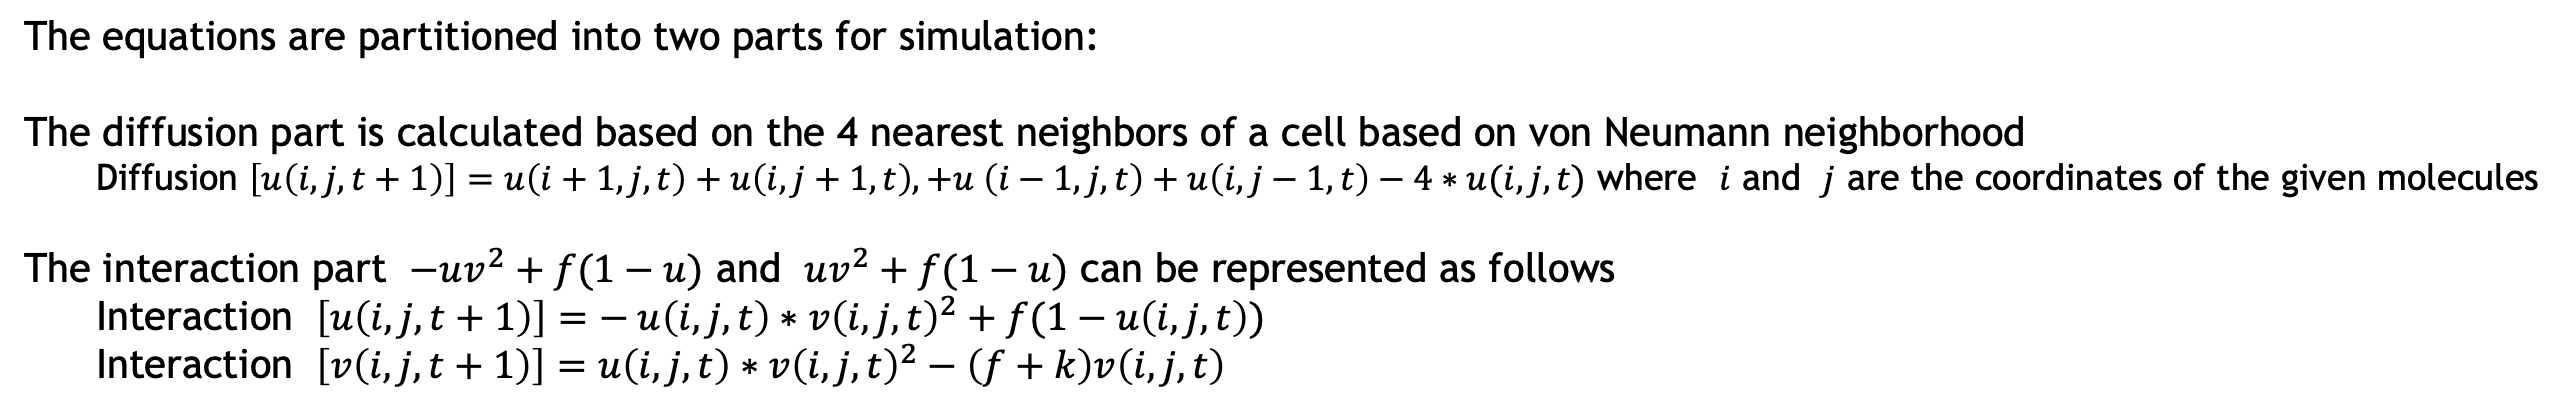

In [ ]:
def init(n):
 
    u = np.ones((n+2,n+2))
    v = np.zeros((n+2,n+2))
    
    x, y = np.meshgrid(np.linspace(0, 1, n+2), np.linspace(0, 1, n+2))

    mask = (0.4<x) & (x<0.6) & (0.4<y) & (y<0.6)
   
    u[mask] = 0.5
    v[mask] = 0.25
        
    return u, v

In [ ]:
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

In [ ]:
def diffusion(u):
    """
    second order finite differences; diffusion calculated based on Von Neumann neighborhood.
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )


In [ ]:
#laplace transform
def grayscott_sim(U, V, Du, Dv, F, k):
    
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    Lu = diffusion(U)
    Lv = diffusion(V)

    uvv = u*v*v
    
    u += Du*Lu - uvv + F*(1 - u)
    v += Dv*Lv + uvv - (F + k)*v

  
    periodic_bc(U)
    periodic_bc(V)
    
    return U, V


In [ ]:
%%time
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
U, V = init(500)
Du, Dv = 0.16, 0.08
F, k = 0.040, 0.064

#simulate and generate image sequence (gifs)
def create_image(grayscott):
    global U, V
    for t in range(1000):
        U, V = grayscott(U, V, Du, Dv, F, k)
       
    

    V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
    return V_scaled

def create_frames(n, grayscott):

    return [create_image(grayscott) for i in tqdm(range(n))]

CPU times: user 98.9 ms, sys: 13 ms, total: 112 ms
Wall time: 248 ms


In [ ]:
frames = create_frames(100, grayscott_sim)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def display_sequence(iframe):
    
    return Image.fromarray(frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

interactive(children=(IntSlider(value=0, description='iframe', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.display_sequence(iframe)>

In [ ]:
frames_scaled = [np.uint8(255 * frame) for frame in frames]
imageio.mimsave('movie16,08,06,062-0-1initia.gif', frames_scaled, format='gif', fps=5)